# Comparing weather data to collision data in New York

A hypothesis suggesting collisions in New York is correlated to the weather was made and this is a report looking to compare the two to see if there is any validity in the theory.

This report will look at data on Google's BigQuery uploaded by a weather station in Central Park, New York, and comparing it to collisions recorded by the New York police. The collisions will be sorted by borough to try and get a more precise correlation between regional driving styles and weather patterns.

### Page setup

This is some set up to run this document.

`save_collision_data` will save the collision data, the collision data with GPS only, the weather data grabbed by Big Query and the One Hot Encoded data to their google drive.

`use_bigquery` requires the user to authenticate themselves on Google but will grab the data from a fresh query.

`find_boroughs` takes a while to process, about 15 minutes, and will be required if `use_bigquery` is set to `True`.

If `use_bigquery` and `find_boroughs` are set to `False` then the data will be pulled from presaved `.csv` files.  

`drive` and `auth` are booleans set to false to load the user's Google Drive if it does not exist. This is required for saving data or using BigQuery

In [140]:
save_collision_data = True
use_bigquery = False
find_borough = False

# Keep False
drive = False
auth = False

This is an assignment for Data Analytics on the Web, a short course with the Univesity of the Highlands and Islands. 

This will look at collision data from New York and attempt to fix some of the missing data. As a pretext, some of the missing `borough` data may be missing for a reason, in that it would not exist, but the data being filled in is purely for the exercise.

The collision data will then be combined with data from the weather station in central park to see if weather may have an adverse affect on driving conditions. The purpose of finding the `borough` is to optimise data by finding any correlation that may bias the data by bad driving in a particular neighborhood.

The Machine Learning models used in this particular assignment will be Linear Regression and Neural Networks. 

# Setting up Google
To begin the data will be taken from Google's data warehouse BigQuery, and that requires the user to be signed in.

In [29]:
if use_bigquery:
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')

### Google Colab Data Table enable 

Google has an optional `google.colab.data_table` function that can be enabled to view large pandas dataframes as interactive tables.

In [30]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


### Setting up BigQuery
Because this assignment will be drawing its data from BigQuery a project name has to be used.

The project name I have used for my assignment is `uhi-project-20023167`.

*Though I am unsure if following users may have to set up their own unique **cloud console project** to run this code.*

In [31]:
project_id = 'uhi-project-20023167'

### Making a query

The `bigquery` function will be imported from `google.cloud`. This is to create a `client` object for which to make a query with. The project id declaired above will be assigned, telling BigQuery what project the query is with.

The query itself is made as a string block with SQL syntax. 

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import requests

def get_csv_data(url):
  data = requests.get(url).content
  return pd.read_csv(io.StringIO(data.decode('utf-8')), index_col=0)


if use_bigquery:
  # Grabbing Weather data
  weather_df = pd.io.gbq.read_gbq('''
    SELECT * 
    FROM `uhi-project-20023167.assignment.weather_2012_to_2020`
    ''', project_id=project_id, dialect='standard')

  # Grabbing collision data that has boroughs filled in
  collision_df = pd.io.gbq.read_gbq('''
    SELECT *
    FROM `uhi-project-20023167.assignment.collision_known`
    ''', project_id=project_id, dialect='standard' )
  
  if find_borough:
    # Grabbing collision data that has does not have boroughs but does have GPS data
    collision_gps_df = pd.io.gbq.read_gbq('''
      SELECT *
      FROM `uhi-project-20023167.assignment.collision_gps_known`
      ''', project_id=project_id, dialect='standard' )
    
    find_borough = True
    
  else:
    # Grab the collision data with the boroughs filled in
    url_gps_collision = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_gps_Borough_Found_for_New_York_2012-2020.csv'
    collision_gps_df = get_csv_data(url_gps_collision)
  
  # Collision data without borough or GPS data
  # collision_unknown_df = pd.io.gbq.read_gbq('''
  #   SELECT *
  #   FROM `uhi-project-20023167.assignment.collision_unknown`
  #   ''', project_id=project_id, dialect='standard' )

  if save_collision_data:
    if not drive:
      from google.colab import drive
      drive.mount('drive')

    weather_df.to_csv('Tom_Blackwood-Weather_data_for_New_York_2012-2020.csv')
    !cp Tom_Blackwood-Weather_data_for_New_York_2012-2020.csv "drive/My Drive"

    half_collision = int((collision_df.index[-1])/2)
    collision_df_pt1 = collision_df[:half_collision].reset_index()
    collision_df_pt2 = collision_df[half_collision + 1:].reset_index()

    collision_df_pt1.to_csv('Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt1.csv')
    !cp Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt1.csv "drive/My Drive"

    collision_df_pt2.to_csv('Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt2.csv')
    !cp Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt2.csv "drive/My Drive"
    
    collision_gps_df.to_csv('Tom_Blackwood-Collision_data_gps_known_for_New_York_2012-2020.csv')
    !cp Tom_Blackwood-Collision_data_gps_known_for_New_York_2012-2020.csv "drive/My Drive"

    print("Dataset Successfully Saved!")

else:
  url_weather = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Weather_data_for_New_York_2012-2020.csv'
  url_collision_pt1 = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt1.csv'
  url_collision_pt2 = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_known_for_New_York_2012-2020_pt2.csv'

  weather_df = get_csv_data(url_weather)
  collision_df_pt1 = get_csv_data(url_collision_pt1)
  collision_df_pt2 = get_csv_data(url_collision_pt2)

  collision_df = collision_df_pt1.append(collision_df_pt2, ignore_index=True)
  collision_df.set_index('index', inplace=True)
  collision_df.reset_index()

  if find_borough:
    # Grab the collision data without the boroughs filled in
    url_gps_collision = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_gps_known_for_New_York_2012-2020.csv'
    collision_gps_df = get_csv_data(url_gps_collision)

  else:
    # Grab the collision data with the boroughs filled in
    url_gps_collision = 'https://raw.githubusercontent.com/20023167uhi/DataAnalytics/main/Data%20Analytics%20on%20the%20Web/Assignment%201/Data/Tom_Blackwood-Collision_data_gps_Borough_Found_for_New_York_2012-2020.csv'
    collision_gps_df = get_csv_data(url_gps_collision)
  
  weather_df['date'] = pd.to_datetime(weather_df['date'])
  collision_df['timestamp'] = pd.to_datetime(collision_df['timestamp'])
  collision_gps_df['timestamp'] = pd.to_datetime(collision_gps_df['timestamp'])

main_boroughs_count = collision_df['borough'].value_counts() # Gives count of collisions in each boroughs of the main dataset


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


The data is created using 3 queries:

Query | Specifying Not `Null` Values Selected | Specifying `Null` Values  Selected
---|---|---
`collision_known`| `borough` |  -
`collision_gps_known` | `longitude`, `latitude`, `location`| `borough` 
`collision_unknown` | `cross_street_name`, `on_street_name`, `off_street_name`|`borough`, `longitude`, `latitude`, `location`

The entry `borough` is the detail sought. Some entries have this detail known, which are gathered for the main dataset. Where the `borough` is unknown two methods are proposed for finding it. The first is using GPS data, `longitude` and `latitude`, to put a name to location using addressing data, and the second would be to create a probability of collisions based on the former datasets where a relationship between `borough` and `*_street_name`. Directly relating `*_street_name` to  `borough` may lead to inconsistencies where a street could run through more than one `borough`.

In [33]:
collision_gps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356548 entries, 0 to 356547
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   borough            356127 non-null  object        
 1   timestamp          356548 non-null  datetime64[ns]
 2   latitude           356548 non-null  float64       
 3   longitude          356548 non-null  float64       
 4   location           356548 non-null  object        
 5   cross_street_name  49298 non-null   object        
 6   on_street_name     281621 non-null  object        
 7   off_street_name    13435 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 24.5+ MB


In [34]:
collision_gps_df.head()

,borough,timestamp,latitude,longitude,location,cross_street_name,on_street_name,off_street_name
0,MANHATTAN,2020-11-10 22:01:00,40.790253,-73.936850,"(40.790253, -73.93685)",NaN,FDR DRIVE,NaN
1,MANHATTAN,2020-11-29 17:23:00,40.830845,-73.947235,"(40.830845, -73.947235)",NaN,WEST 152 STREET,NaN
2,BROOKLYN,2020-10-25 11:15:00,40.678394,-73.946920,"(40.678394, -73.94692)",NaN,ATLANTIC AVENUE,NaN
3,BROOKLYN,2020-11-13 12:21:00,40.637096,-73.934650,"(40.637096, -73.93465)",NaN,TROY AVENUE,NaN
4,BRONX,2020-09-05 08:10:00,40.826275,-73.859710,"(40.826275, -73.85971)",BRUCKNER BOULEVARD,WHITE PLAINS ROAD,NaN


## Filling in GPS data using the Python Package `uszipcode`

The `borough` column from `collision_gps_*` is completely `null`. To fix these entries, a python package `uszipcode` is used to look up addresses using GPS data. The package `uszipcode` is not naturally available on colab so it must be installed by the cell below.

In [35]:
!pip --quiet install uszipcode 

The SearchEngine object from `uszipcode` is imported and assigned to a variable to be used in a pandas `.apply()` method, which takes the longitude and latitude data, performs a search and returns a list result objects.

The `uszipcode.SearchEngine` allows a search to be performed `by_coordinates`, which takes in a latitude and longitude by `lat` and `lng`, performs a search within a `radius`, in miles, and can return a specified number of results. The results are returns as a list result objects, and the first one is selected with `[0]` which holds the details about that partiuclar 'closest' zip code. From the results, the `major_city` element of the object will largely find the borough but it sometimes finds neighbourhoods of the boroughs. For this lists of the neighbourhoods have been created to filter the result into their appropriate borough. 

The returned `major_city` or filtered `borough` will be in string format, which will be useful for encoding the counts of collisions later.

If no `major_city` objects are returned then the function below returns a `None` with, which will be dropped later using a function as that data will be considered unusuable. (Possibly due to instrumentation error or a response outwith the GPS domain of New York.) 

There may be a better/quicker way to do this.

*(if running, it will take a while. Feel free to fetch that second cup of tea...)*

In [36]:
from uszipcode import SearchEngine

search = SearchEngine(simple_zipcode=True) # set simple_zipcode=True to not use rich info database

STATEN_ISLE_loc = ["Staten Island", "Annadale", "Arden Heights", "Arlington", "Arrochar", "Bay Terrace", "Bloomfield", 
                   "Brighton Heights", "Bulls Head", "Castleton Corners", "Charleston", "Chelsea", "Clifton", 
                   "Concord", "Dongan Hills", "Egbertville", "Elm Park", "Eltingville", "Emerson Hill", 
                   "Fort Wadsworth", "Graniteville", "Grant City", "Grasmere", "Great Kills", "Greenridge", 
                   "Grymes Hill", "Hamilton Park", "Heartland Village", "Huguenot", "Lighthouse Hill", "Livingston", 
                   "Manor Heights", "Mariners Harbor", "Meiers Corners", "Midland Beach", "New Brighton", "New Dorp",
                   "New Springville", "Oakwood", "Old Place", "Old Town", "Pleasant Plains", "Port Ivory", 
                   "Port Richmond", "Prince's Bay", "Randall Manor", "Richmond Valley", "Richmondtown", "Rosebank", 
                   "Rossville", "Saint George", "Sandy Ground", "Shore Acres", "Silver Lake", "South Beach", "Stapleton", 
                   "Stapleton Heights", "Sunnyside", "Todt Hill", "Tompkinsville", "Tottenville", "Tottenville Beach",
                   "Travis", "Ward Hill", "West New Brighton", "Westerleigh", "Willowbrook", "Woodrow"]
                   
MANHATTAN_loc = ["New York", "Manhattan", "Upper Manhattan", "Marble Hill", "Inwood", "Fort George", 
                 "Washington Heights", "Hudson Heights", "West Harlem", "Hamilton Heights", 
                 "Manhattanville", "Morningside Heights", "Central Harlem", "Harlem", 
                 "St. Nicholas Historic District", "Strivers' Row", "Astor Row", "Sugar Hill", 
                 "Central Harlem", "Marcus Garvey Park, Mount Morris Historical District", 
                 "Le Petit Senegal", "Little Senegal", "East Harlem (Spanish Harlem)", "Upper East Side", 
                 "Lenox Hill", "Carnegie Hill", "Yorkville", "Upper West Side", "Manhattan Valley", 
                 "Bloomingdale District", "Lincoln Square", "San Juan Hill", "Flower District", "Brookdale", 
                 "Hudson Yards", "Kips Bay", "Rose Hill", "NoMad", "Peter Cooper Village", "Gas House district",
                 "Chelsea", "Flatiron District", "Toy District", "Photo District", "Gramercy Park", 
                 "Stuyvesant Square", "Union Square", "Stuyvesant Town", "Meatpacking District", 
                 "Waterside Plaza", "Downtown Manhattan", "Little Germany", "Alphabet City and Loisaida",
                 "East Village", "Greenwich Village", "NoHo", "Bowery", "West Village", "Lower East Side",
                 "SoHo", "Nolita", "NoLIta", "Little Australia", "Little Italy", "Chinatown", "Financial District",
                 "Five Points", "Cooperative Village†", "Two Bridges", "Tribeca", "TriBeCa", "Civic Center", 
                 "Radio Row", "South Street Seaport Historical District", "Battery Park City", "Little Syria"]

BRONX_loc = ["Bronx", "Northwest Bronx", "Bedford Park", "Belmont (Arthur Avenue)", "Belmont", "Arthur Avenue", 
             "Fordham", "Fordham Heights", "Fordham Manor", "Jerome Park", "Kingsbridge", "Kingsbridge Heights", 
             "Van Cortlandt Village", "Marble Hill", "Norwood", "Riverdale", "Central Riverdale", "Fieldston", 
             "Hudson Hill", "North Riverdale", "Spuyten Duyvil (South Riverdale)", "University Heights", 
             "Woodlawn Heights (North of Woodlawn Cemetery)", "Woodlawn Heights", "Southwest Bronx", "Bathgate", 
             "Claremont", "Concourse", "East Tremont", "Highbridge", "Hunts Point", "Longwood", "Foxhurst", 
             "Woodstock", "Melrose", "Morris Heights", "Morrisania", "Crotona Park East", "Mott Haven", 
             "Port Morris", "The Hub", "Tremont", "Fairmount", "Mount Eden", "Mount Hope", "West Farms", 
             "East Bronx", "Northeast Bronx", "Allerton", "Bronxwood", "Laconia", "Baychester", "Bronxdale", 
             "City Island", "Co-op City", "Eastchester", "Edenwald", "Pelham", "Pelham Gardens", "Pelham Parkway", 
             "Wakefield", "Washingtonville", "Williamsbridge", "Olinville", "Southeast Bronx", 
             "Bronx River (on the border of East and West)", "Bronx River", "Bruckner", "Clason Point", 
             "Country Club", "Harding Park", "Morris Park", "Indian Villag", "Parkchester", "Park Versailles", 
             "Pelham Bay", "Soundview", "Schuylerville", "Throggs Neck (also spelled Throgs Neck)", 
             "Throggs Neck", "Throgs Neck", "Edgewater Park", "Unionport", "Castle Hill", "Van Nest", 
             "Westchester Heights", "Westchester Square", "The Pelham Islands", "The Blauzes", 
             "Chimney Sweeps Islands", "City Island", "Hart Island", "High Island", "Hunter Island", 
             "Rat Island", "Twin Island", "North Brother Island", "South Brother Island", "Rikers Island"]

QUEENS_loc = ['Queens', 'Astoria', 'Astoria Heights', 'Ditmars', 'Steinway', 'Little Egypt', 'Jackson Heights', 
              'Long Island City', 'Blissville', 'Hunters Point', 'Dutch Kills', 
              'Queensbridge', 'Queensbridge (housing development)', 'Queensview', 'Queensview (housing development)', 
              'Queens West', 'Ravenswood', 'Ravenswood (housing development)', 'Sunnyside', 'Sunnyside Gardens', 
              'Northeastern Queens', 'Bayside', 'Bay Terrace', 'Bayside Hills', 'Fort Totten', 
              'Oakland Gardens', 'Bellerose', 'College Point', 'Douglaston–Little Neck', 'Douglaston', 
              'Douglas Bay', 'Douglas Manor', 'Douglaston Hill', 'Douglaston Park', 'Winchester Estates', 
              'Little Neck', 'Pines', 'Little Neck Hills', 'Westmoreland', 'Flushing', 'Auburndale', 
              'Broadway-Flushing', 'Bowne Park', 'Chinatown', 'Downtown Flushing', 'Kew Gardens Hills', 
              'Koreatown', 'Linden Hill', 'Murray Hill', 'Willets Point', 'Pomonok', 'Electchester', 
              'Queensboro Hill', 'Floral Park', 'Fresh Meadows', 'Hillcrest', 'Utopia', 'Glen Oaks', 
              'North Shore Towers', 'North Shore Towers (housing development)', 'Whitestone', 'Beechhurst', 
              'Clearview', 'Malba', 'Central Queens', 'Briarwood', 'Corona', 'LeFrak City', 
              'LeFrak City (housing development)', 'North Corona', 'East Elmhurst', 'Elmhurst', 
              'Forest Hills', 'Forest Hills Gardens', 'Fresh Pond', 'Glendale',
              'Jackson Heights', 'Kew Gardens', 'Maspeth', 'Middle Village', 'Rego Park', 'Ridgewood', 
              'Wyckoff Heights', 'Woodside', 'Southeastern Queens', 'Bellaire', 'Brookville', 
              'Cambria Heights', 'Hollis Hills', 'Hollis', 'Holliswood', 'Jamaica', 'Jamaica Estates', 
              'Jamaica Hills', 'Laurelton', 'Meadowmere', 'Queens Village', 'Rochdale Village', 
              'Rochdale Village (Cooperative Housing Development)', 'Rosedale', 'Saint Albans', 
              'South Jamaica', 'Springfield Gardens', 'Warnerville', 'Southwestern Queens', 
              'The Hole', 'Howard Beach', 'Hamilton Beach', 'Howard Park', 
              'Lindenwood ', 'Lindenwood (housing development)', 'Old Howard Beach', 'Ramblersville', 
              'Rockwood Park', 'Ozone Park', 'South Ozone Park', 'Tudor Village', 'Richmond Hill',
              'South Richmond Hill', 'Elmont', 'Valley Stream', 
              'Woodhaven', 'The Rockaways', 'Main article: Rockaway, Queens', 'Arverne', 'Bayswater', 
              'Belle Harbor', 'Breezy Point', 'Broad Channel', 'Edgemere', 'Far Rockaway', 'Hammels', 
              'Neponsit', 'Rockaway Beach', 'Rockaway Park', 'Roxbury', 'Seaside']

BROOKLYN_loc = ["Brooklyn", "Central Brooklyn", "Crown Heights", "Weeksville", "Flatbush", "Beverley Squares ", 
                "Beverley Square East ", "Beverley Square West", "Ditmas Park", "East Flatbush", "Farragut", 
                "Remsen Village", "Fiske Terrace", "Pigtown", "Wingate", "Prospect Park area", 
                "Prospect Lefferts Gardens", "Prospect Park South", "Windsor Terrace[1]", "Windsor Terrace", "Kensington", 
                "Ocean Parkway", "Parkville", "Eastern Brooklyn", "Brownsville", "Canarsie", 
                "East New York", "City Line", "Cypress Hills", "New Lots", "Spring Creek", "Starrett City", 
                "Highland Park", "Northern Brooklyn", "Bedford–Stuyvesant[2]", "Bedford–Stuyvesant", 
                "Bedford", "Ocean Hill", "Stuyvesant Heights", "Bushwick", "Wyckoff Heights", 
                "East Williamsburg", "Greenpoint", "Little Poland", "Williamsburg", "Northwestern Brooklyn", 
                "Brooklyn Heights", "Brooklyn Navy Yard", "Admiral's Row", "Cadman Plaza", "Clinton Hill", 
                "Downtown Brooklyn", "Bridge Plaza/RAMBO", "DUMBO", "Fulton Ferry", "Fort Greene", 
                "Prospect Heights", "Pacific Park/Atlantic Yards", "Vinegar Hill", "South Brooklyn", 
                "Boerum Hill", "Carroll Gardens", "Columbia Street Waterfront District", "Cobble Hill", 
                "Gowanus", "Park Slope", "South Park Slope", "Greenwood Heights", "Red Hook", 
                "Southern Brooklyn", "Barren Island", "Bergen Beach and Georgetown", "Bergen Beach", 
                "Georgetown", "Coney Island", "Brighton Beach", "Little Odessa", "West Brighton", 
                "Manhattan Beach", "Sea Gate", "Sheepshead Bay and Madison", "Madison", "Sheepshead Bay", 
                "Homecrest", "Midwood", "Flatlands", "Gerritsen Beach", "Gravesend", "White Sands", 
                "Marine Park", "Mill Basin", "Plumb Beach", "Bay Ridge", "Fort Hamilton", "Bensonhurst", 
                "Bath Beach", "New Utrecht", "Borough Park", "Mapleton ", "Bensonhurst", "Dyker Heights", 
                "Sunset Park", "Chinatown", "Sunset Industrial Park", "Bushwick", "Bushwick", "Greenpoint",
                "Williamsburg", "Brooklyn", "Bedford-Stuyvesant", "Boerum Hill", "Carroll Gardens", 
                "Cobble Hill", "Brooklyn Heights", "Brownsville", "City Line", "Clinton Hill", 
                "Crown Heights", "Cypress Hills", "Downtown Brooklyn", "DUMBO", "East New York", 
                "Fort Greene", "Gowanus", "Greenwood Heights", "Highland Park", "New Lots", "Ocean Hill",
                "Park Slope", "Prospect Heights", "RAMBO", "Spring Creek", "Starrett City", 
                "Stuyvesant Heights", "Sunset Park", "Vinegar Hill", "Weeksville", "Windsor Terrace",
                "Wingate", "Flatlands", "Bergen Beach", "Canarsie", "Flatlands", "Georgetown", 
                "Marine Park", "Mill Basin", "The southeastern quarter of Midwood", "Gravesend",
                "Brighton Beach", "Coney Island", "Gerritsen Beach", "Gravesend", "Homecrest", 
                "Madison", "Midwood", "Manhattan Beach", "Plum Beach", "Seagate", "Sheepshead Bay",
                "New Utrecht", "Bay Ridge", "Borough Park", "Dyker Heights", "Mapleton", "New Utrecht",
                "Bath Beach", "Bensonhurst", "Flatbush", "Ditmas Park", "East Flatbush", "Farragut",
                "Fiske Terrace", "Flatbush", "Kensington", "Prospect Lefferts Gardens", "Prospect Park South"]

def get_zip_code(lat, long):
  print(search.by_coordinates(lat=lat, lng=long, radius=5, returns=5))
  try:
    zip_result = search.by_coordinates(lat=lat, lng=long, radius=5, returns=1)[0]
    return zip_result.zipcode
  except: 
    return None

def gps_get_borough(lat, long, make_print=False):
  if make_print:
    print(search.by_coordinates(lat=lat, lng=long, radius=5, returns=5))
    print(search.by_coordinates(lat=lat, lng=long, radius=5, returns=1)[0].county)
  
  try:
    borough_result = search.by_coordinates(lat=lat, lng=long, radius=5, returns=1)[0].major_city
    if borough_result in STATEN_ISLE_loc:
      return 'STATEN ISLAND'
    elif borough_result in BRONX_loc:
      return 'BRONX'
    elif borough_result in MANHATTAN_loc:
      return 'MANHATTAN'
    elif borough_result in QUEENS_loc:
      return 'QUEENS'
    elif borough_result in BROOKLYN_loc:
      return 'BROOKLYN'
    elif borough_result:
      return borough_result.upper()
    else:
      return np.nan
  
  except:
    return np.nan

if find_borough:
  collision_gps_df['borough'] = collision_gps_df.apply(lambda x: gps_get_borough(lat=x['latitude'], long=x['longitude']), axis=1) # Finds boroughs by using GPS coordinates

  if save_collision_data:
    if not drive:
      from google.colab import drive
      drive.mount('drive')

    collision_gps_df.to_csv('Tom_Blackwood-Collision_data_gps_Borough_Found_for_New_York_2012-2020.csv')
    !cp Tom_Blackwood-Collision_data_gps_Borough_Found_for_New_York_2012-2020.csv "drive/My Drive"

    print("Dataset Successfully Saved!")


In [37]:
collision_gps_df.head()

,borough,timestamp,latitude,longitude,location,cross_street_name,on_street_name,off_street_name
0,MANHATTAN,2020-11-10 22:01:00,40.790253,-73.936850,"(40.790253, -73.93685)",NaN,FDR DRIVE,NaN
1,MANHATTAN,2020-11-29 17:23:00,40.830845,-73.947235,"(40.830845, -73.947235)",NaN,WEST 152 STREET,NaN
2,BROOKLYN,2020-10-25 11:15:00,40.678394,-73.946920,"(40.678394, -73.94692)",NaN,ATLANTIC AVENUE,NaN
3,BROOKLYN,2020-11-13 12:21:00,40.637096,-73.934650,"(40.637096, -73.93465)",NaN,TROY AVENUE,NaN
4,BRONX,2020-09-05 08:10:00,40.826275,-73.859710,"(40.826275, -73.85971)",BRUCKNER BOULEVARD,WHITE PLAINS ROAD,NaN


In [38]:
borough_counts = collision_gps_df['borough'].value_counts()
collision_threshold = 1000

print(f"""From the GPS dataset:
Number of 'borough' entries filled: {sum(borough_counts)} / {len(collision_gps_df)} = {round(sum(borough_counts) / len(collision_gps_df), 3) * 100}%

Total number of boroughs: {len(borough_counts)}
Number of boroughs with more than {collision_threshold} collisions: {len(borough_counts[borough_counts > collision_threshold])} / {len(borough_counts)} = {round(len(borough_counts[borough_counts > collision_threshold]) / len(borough_counts) * 100, 3)}%
Entries lost by dropping boroughs with less than {collision_threshold} collisions: {sum(borough_counts[borough_counts < collision_threshold])} / {sum(borough_counts)} = {round(sum(borough_counts[borough_counts < collision_threshold])/sum(borough_counts) * 100, 3)}%

Percentage of collisions dropped where boroughs could not be found: {round(sum(collision_gps_df[collision_gps_df['borough'].isna()]['location'].value_counts())/sum(borough_counts) * 100, 3)}%

GPS coordinates where a borough could not be found: 
{collision_gps_df[collision_gps_df['borough'].isna()]['location'].value_counts()}""")

From the GPS dataset:
Number of 'borough' entries filled: 356127 / 356548 = 99.9%

Total number of boroughs: 27
Number of boroughs with more than 1000 collisions: 5 / 27 = 18.519%
Entries lost by dropping boroughs with less than 1000 collisions: 130 / 356127 = 0.037%

Percentage of collisions dropped where boroughs could not be found: 0.118%

GPS coordinates where a borough could not be found: 
(0.0, 0.0)                 296
(40.75837, -201.23706)     105
(40.665226, -32.768513)     16
(40.556175, -47.209625)      3
(40.854286, -201.35999)      1
Name: location, dtype: int64


The number of empty entries in boroughs filled by using the gps data is 99.9%. 27 unique boroughs and neighbourhoods were found but some of the neighbourhoods with low collisions are from New Jersey and so outwith the scope of this project.

By creating a threshold of 1,000 collision counts, 22 boroughs are dropped as being superfluous information, leaving only 5 boroughs to process. By dropping the neighborhoods with less than 1000 collisions, only 0.037%, 130 entries from the dataset, of the data will be lost.

Locations where GPS coordinates could not find a neighbourhood or borough account for 0.118% of results. Printing `value_counts()` of the `location` where `boroughs` were of `NoneType` shows that the values would most likely be due to instrumentation error or an incorrect value when the data was entered.

Dropping both the values outwith the scope and values appearing in error will account for a loss of less than 0.2% of the GPS converted data. 

The collision counts for each borough and neighborhood is shown as: 

In [39]:
borough_counts

QUEENS              119300
BROOKLYN             88090
MANHATTAN            67449
BRONX                53075
STATEN ISLAND        28083
CEDARHURST              36
FORT LEE                36
YONKERS                 14
ATLANTIC BEACH           9
NESHANIC STATION         7
SEWAREN                  5
ARMONK                   4
MOUNT VERNON             4
BLAUVELT                 2
NEW HYDE PARK            1
ATHENS                   1
CENTRAL SQUARE           1
VESTAL                   1
BAYONNE                  1
CORRY                    1
NEW ROCHELLE             1
ANGOLA                   1
GARRISON                 1
GREAT NECK               1
CARTERET                 1
TOMKINS COVE             1
MC HENRY                 1
Name: borough, dtype: int64

## Combining the collision data with the GPS corrected collision data

The index values from the `value_count()` of `collision_df` can be used to filter the preferential values from the GPS obtained boroughs. The original values and the salvaged boroughs can then be appended together which will provide more details for when it comes to setting the parameters of the machine learning model.  

In [40]:
print(f"""
The dataset count of collisions complete with boroughs is:
{main_boroughs_count}

The count of collisions added to the dataset from finding the borough from the GPS coordinates are: 
{borough_counts[borough_counts.index.isin(main_boroughs_count.index)]}
""")


The dataset count of collisions complete with boroughs is:
BROOKLYN         376610
QUEENS           322223
MANHATTAN        282066
BRONX            172029
STATEN ISLAND     51073
Name: borough, dtype: int64

The count of collisions added to the dataset from finding the borough from the GPS coordinates are: 
QUEENS           119300
BROOKLYN          88090
MANHATTAN         67449
BRONX             53075
STATEN ISLAND     28083
Name: borough, dtype: int64



In [41]:
collision_df2 = collision_df.append(collision_gps_df[collision_gps_df['borough'].isin(main_boroughs_count.index)], ignore_index=True)
print(f"""
New Complete Collision dataset borough `value_counts()` with additional GPS entries: 
{collision_df2['borough'].value_counts()}
""")


New Complete Collision dataset borough `value_counts()` with additional GPS entries: 
BROOKLYN         464700
QUEENS           441523
MANHATTAN        349515
BRONX            225104
STATEN ISLAND     79156
Name: borough, dtype: int64



A new date column is created so the dataset can be grouped by `date` without time of day being a factor. From that the data will be grouped by `date` and then a `value_counts()` using `borough` will return a count of collisions per day for each borough.

This returned value will be a `MultiIndex` type which combines both the date and the borough in the index. To solve this the `unstack()` function is used. Unstack can break down the data and will name each column after the date, and each row will keep an index value of borough at `level=0`. This easily solved by unstacking at `level=-1` to make the column heads the borough and the row indices of the date value. And each entry under the `borough` column header will hold the number of collisions for that `date` in that `borough`.

The data is now ready to merge with the weather data on the `date` column.

In [42]:
collision_df2['date'] = pd.DatetimeIndex(collision_df2.timestamp).normalize()
collision_df2.head()

,borough,timestamp,latitude,longitude,location,cross_street_name,on_street_name,off_street_name,date
0,QUEENS,2020-10-19 10:00:00,40.665610,-73.83608,"(40.66561, -73.83608)",155 AVENUE,BRIDGETON STREET,NaN,2020-10-19
1,BROOKLYN,2020-10-23 10:05:00,40.677353,-74.00446,"(40.677353, -74.00446)",HUNTINGTON STREET,HICKS STREET,NaN,2020-10-23
2,BRONX,2020-10-09 19:00:00,40.868320,-73.83317,"(40.86832, -73.83317)",EDSON AVENUE,BARTOW AVENUE,NaN,2020-10-09
3,BRONX,2020-11-29 15:10:00,40.881600,-73.90484,"(40.8816, -73.90484)",KINGSBRIDGE AVENUE,WEST 233 STREET,NaN,2020-11-29
4,MANHATTAN,2020-11-14 11:00:00,40.706142,-74.00603,"(40.706142, -74.00603)",MAIDEN LANE,WATER STREET,NaN,2020-11-14


In [43]:
collision_df3 = collision_df2.groupby('date')['borough'].value_counts().unstack(level=-1)
collision_df3.fillna(np.nan, inplace=True)
collision_df3.describe()

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
count,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000
mean,73.180754,151.072822,113.626463,143.538036,25.733420
std,22.829901,37.989171,34.947300,38.246545,10.625317
min,12.000000,21.000000,7.000000,19.000000,2.000000
25%,56.000000,127.000000,96.000000,121.000000,18.000000
50%,70.000000,152.000000,119.000000,145.000000,25.000000
75%,89.000000,177.000000,137.000000,168.000000,33.000000
max,215.000000,293.000000,224.000000,298.000000,94.000000


The day of the week `day`, `month`, `month_number`, `quarter`, and `year` were added to `scattter_plot` to make viewing the data over different periods and highlight seasonal traits in plots. `quarter` is the quartile of the year, so the first quartile is January, February, and March, and the second quartile is April, May, and June, and so on.

In [78]:
plot_height = 2 # Set plot height
plot_aspect = 3 # Set plot aspect ratio

In [ ]:
scatter_plot = collision_df3.copy()
scatter_plot['year'] = scatter_plot.index.year
scatter_plot['quarter'] = scatter_plot.index.quarter
scatter_plot['month'] = scatter_plot.index.month_name()
scatter_plot['day'] = scatter_plot.index.day_name()
scatter_plot['yearday_num'] = scatter_plot.index.dayofyear
scatter_plot['weekday_num'] = scatter_plot.index.dayofweek

scatter_plot = scatter_plot.melt(id_vars=['year', 'quarter', 'month', 'day', 'yearday_num', 'weekday_num'], value_vars=['BRONX', 'BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND'], var_name = 'borough', value_name = 'collisions')

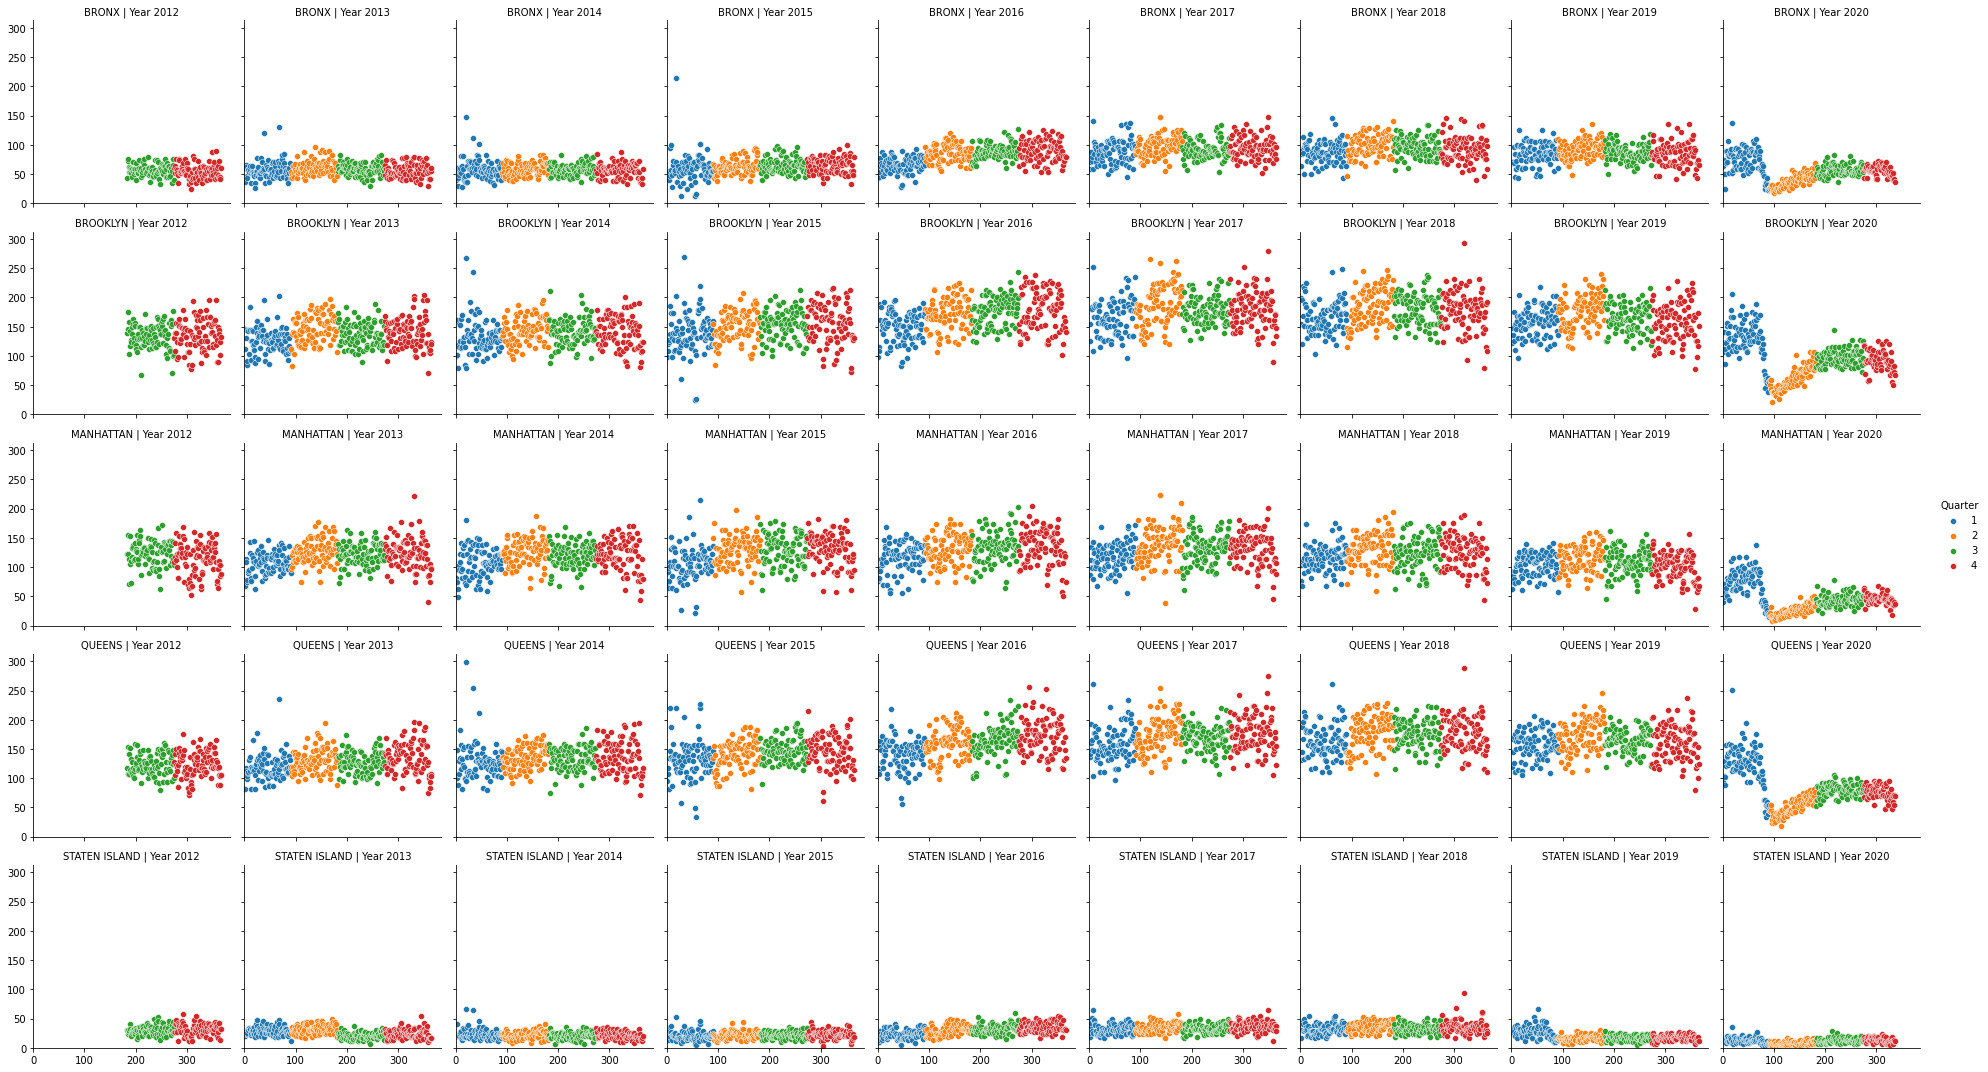

In [44]:
g = sns.FacetGrid(scatter_plot, col = 'year', row = 'borough', hue='quarter', sharey=True)
g.map_dataframe(sns.scatterplot, x="yearday_num", y = 'collisions')
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend(title="Quarter")
g.set(ylim=(0, None), xlim=(0, None))

The data from `complete_df` is plotted in a scatter for each day of the year, in a `FacetGrid` of plots by `year` and `borough`. The plots are highlighted by their annual `quartile`. Looking at the data in the scatter above, there are some odd discrepancies in  the years 2012 and 2020. 

2012 is the beginning year of the collision data, and only half the last 2 quartiles the year of data are recorded, beginning from July. Since a large portion of that year for each borough is missing the data will be dropped.

In 2020 the collision data is influenced by a global lockdown at the end of March, a very odd circumstance, due to the coronavirus of 2019. This will influence the results and so it will be dropped as well.

`STATEN ISLAND` also shows some odd trends, especially in 2013 and 2019. The other collisions for this borough do hold a similar trend but since they are more nebulous in distribution, and Staten Island accounts for the smallest portion of collisions, the borough will be dropped as well.  

A barchart based on collisions on the day of the week across the quartiles of the year, sorted by years and boroughs that should not be dropped in plotted below. 

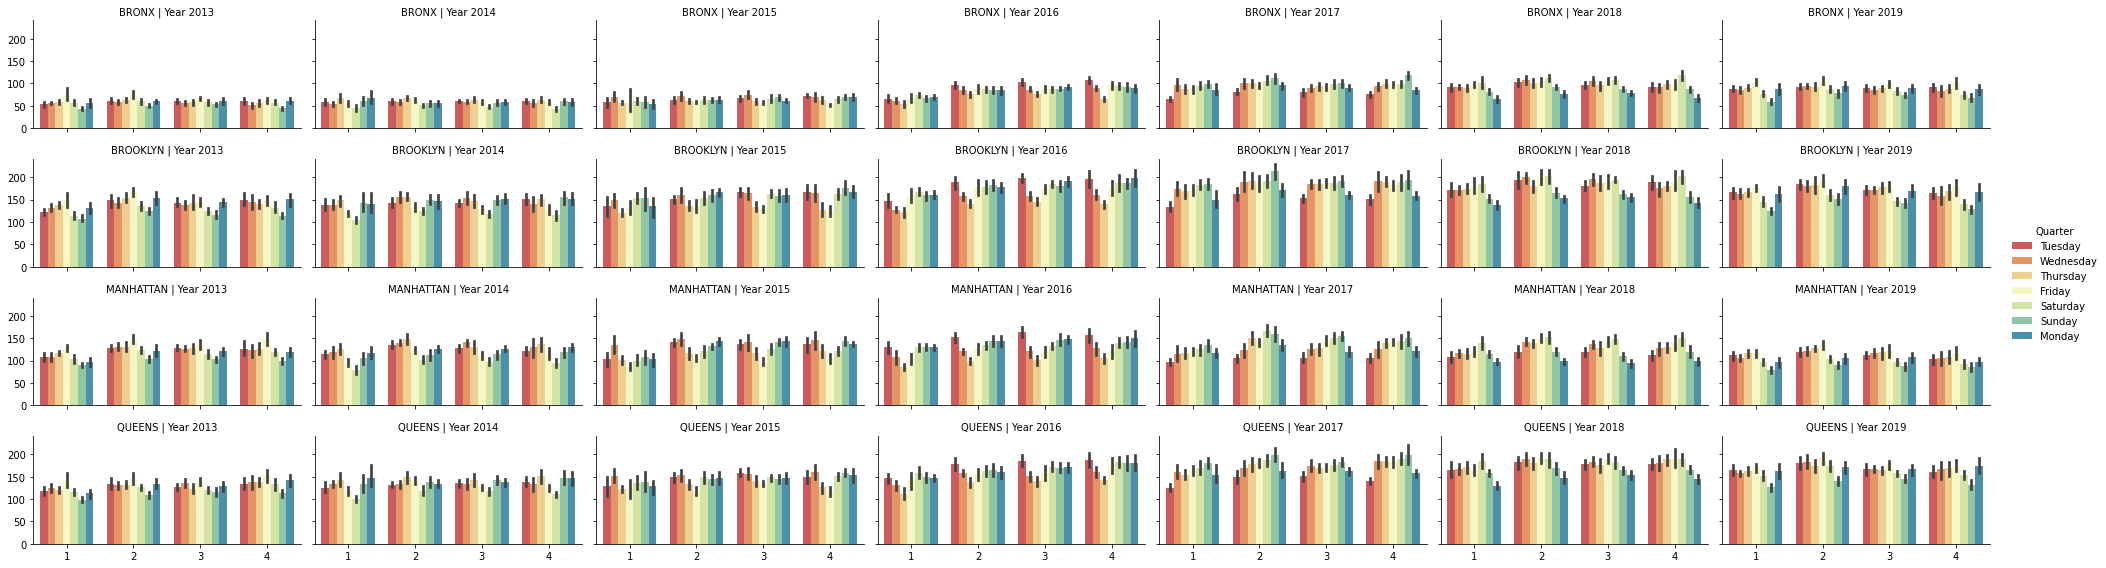

In [80]:
g = sns.FacetGrid(scatter_plot.drop(scatter_plot[(scatter_plot.year == 2012) | (scatter_plot.year == 2020) | (scatter_plot.borough == 'STATEN ISLAND')].index, axis=0), 
                  col = 'year', row = 'borough', sharey=True, height = plot_height, aspect = 2)
g.map_dataframe(sns.barplot, x='quarter', y = 'collisions', hue='day', palette="Spectral")
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend(title="Quarter")
g.set(ylim=(0, None))

The year 2013 begins on a Tuesday which means the dataset begins on a Tuesday. Looking at the data it appears that collisions appear to increase with respect to the day of the week, from Sunday to Friday then drop downwards on a Saturday to Sunday to begin rising again. This can be fixed by sorting values by `weekday_num`, but the week begins on a Monday with a `0`.

The day of the week is starts with `Monday = 0` and ends with `Sunday = 6`. The data from the blue scatter/histogram further below shows a steady increase in collisions until Saturday and drops suddenly on Sunday, so in the interest of finding linear relationships the day numbers of the week will be shifted by one so that `Sunday = 0`, `Monday = 1`, and `Saturday = 6`.

In [46]:
collision_df4 = collision_df3.drop('STATEN ISLAND', axis=1)
collision_df4.drop(collision_df4[(collision_df4.index.year == 2012) | (collision_df4.index.year == 2020)].index, inplace=True)
collision_df4.head()

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS
date,,,,
2013-01-01,36,111,78,82
2013-01-02,60,146,68,105
2013-01-03,66,145,113,117
2013-01-04,62,130,109,112
2013-01-05,46,85,75,98


### Removing the outlier data

To remove the outlier data an estimation can be made to contain the bulk of the data while removing obscure points.

The `describe()` function calculates the `percentiles` which can be describes. Since these are the method being proposed to describe the *working bandwidth* of data, any outlying data will be dropped. Setting the percentiles gives an element of control over the band with which to smooth the data by.

The values from the `describe()` function are saved into a dictionary based on `year` and `month` of the value.

In [47]:
low_percentile = 5
high_percentile = 100 - low_percentile
df_stats = {}

for year in collision_df4.index.year.unique():
  df_stats[str(year)] = {}
  for month in collision_df4.index.month.unique():
    df_stats[str(year)][str(month)] = collision_df4[(collision_df4.index.year == year) & (collision_df4.index.month == month)].describe(percentiles = [low_percentile/100, .5, high_percentile/100])

print(f"""Stats for July 2013: 
{df_stats['2013']['7']}

Stats for July 2015: 
{df_stats['2015']['7']}

{low_percentile}% percentile for July 2015: 
{df_stats['2015']['7'].iloc[4]}

{low_percentile}% percentile for MANHATTAN in July 2015: 
{df_stats['2015']['7']['MANHATTAN'].iloc[4]}
""")

def trim_dataframe(data):
  for date in data.index:
    if df_stats[str(date.year)][str(date.month)][data.name].iloc[4] < data[date] < df_stats[str(date.year)][str(date.month)][data.name].iloc[6]:
      data[date] = data[date]
    else:
      data[date] = np.nan
  return data

collision_df5 = collision_df4.copy()
collision_df5 = collision_df5.apply(lambda x: trim_dataframe(x))

collision_df5.head()

Stats for July 2013: 
borough      BRONX    BROOKLYN   MANHATTAN      QUEENS
count    31.000000   31.000000   31.000000   31.000000
mean     60.967742  138.645161  122.032258  131.322581
std       8.356570   19.872172   20.347783   16.862952
min      45.000000  108.000000   72.000000   96.000000
5%       49.500000  108.500000   85.500000  103.000000
50%      60.000000  140.000000  124.000000  130.000000
95%      74.500000  168.500000  152.000000  156.000000
max      82.000000  184.000000  163.000000  174.000000

Stats for July 2015: 
borough      BRONX    BROOKLYN   MANHATTAN      QUEENS
count    31.000000   31.000000   31.000000   31.000000
mean     63.387097  150.516129  130.935484  145.451613
std      11.206181   24.843337   29.822738   18.266251
min      40.000000  100.000000   60.000000   90.000000
5%       49.500000  107.500000   87.000000  121.000000
50%      62.000000  155.000000  132.000000  146.000000
95%      83.500000  189.000000  174.500000  168.500000
max      93.000000  

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS
date,,,,
2013-01-01,36.0,111.0,78.0,NaN
2013-01-02,60.0,146.0,NaN,105.0
2013-01-03,NaN,145.0,113.0,117.0
2013-01-04,62.0,130.0,109.0,112.0
2013-01-05,46.0,NaN,75.0,98.0


The selected and outlier-trimmed scattered data now looks like:

In [48]:
trim_plot = collision_df5.copy()
trim_plot['year'] = trim_plot.index.year
trim_plot['quarter'] = trim_plot.index.quarter
trim_plot['month'] = trim_plot.index.month_name()
trim_plot['day'] = trim_plot.index.day_name()
trim_plot['yearday_num'] = trim_plot.index.dayofyear
trim_plot['weekday_num'] = trim_plot.index.dayofweek
trim_plot['weekday_num'] = trim_plot['weekday_num'].apply(lambda x: 0 if x == 6 else x + 1)

trim_plot = trim_plot.melt(id_vars=['year', 'quarter', 'month', 'day', 'yearday_num', 'weekday_num'], value_vars=collision_df5.columns, var_name = 'borough', value_name = 'collisions')

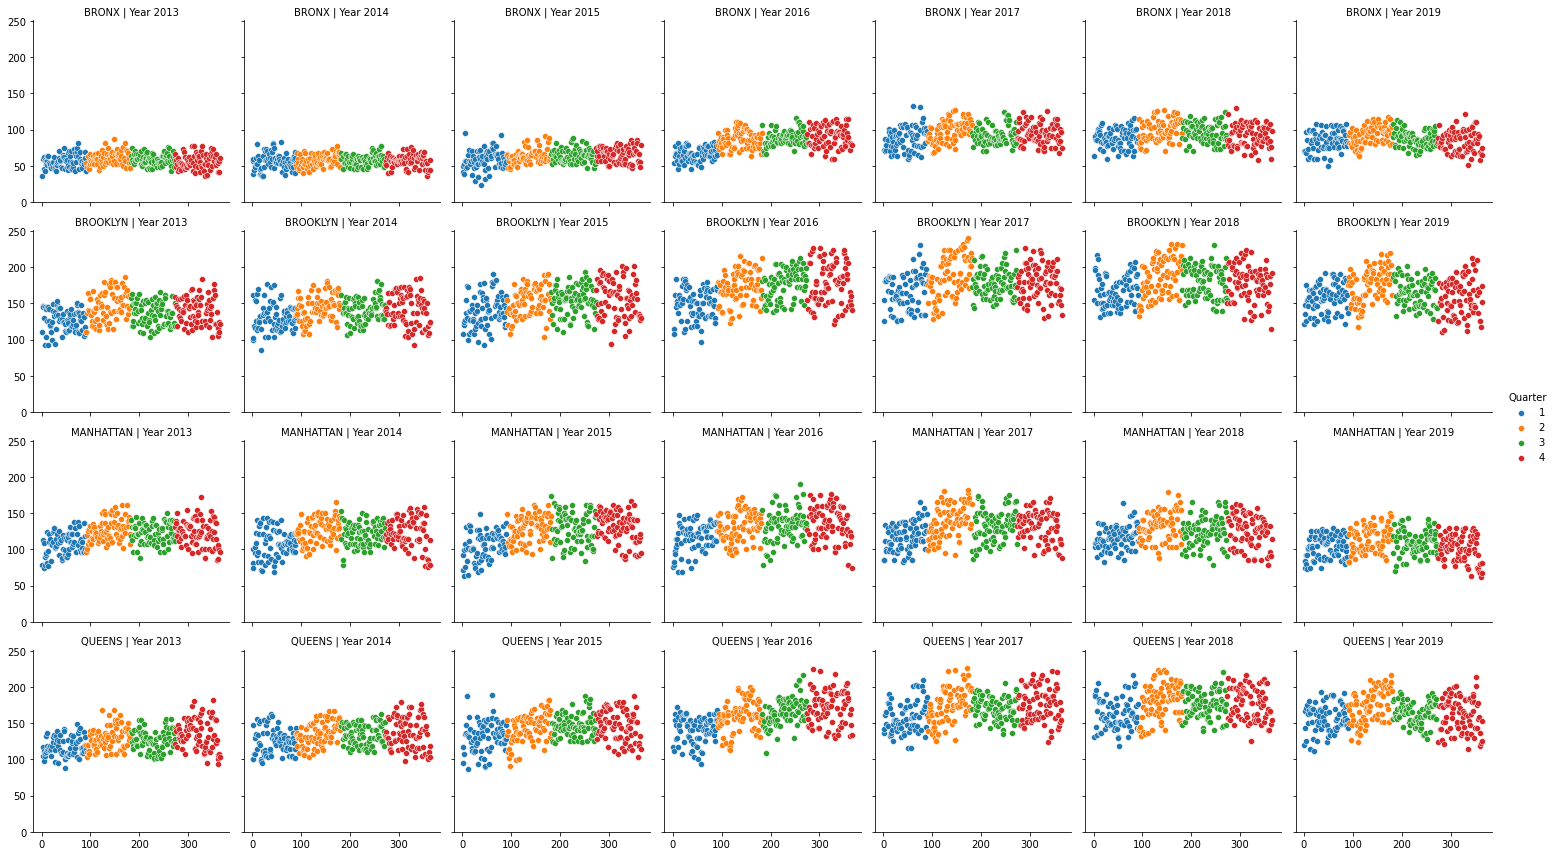

In [49]:
g = sns.FacetGrid(trim_plot, col = 'year', row = 'borough',hue='quarter', sharey=True)
g.map_dataframe(sns.scatterplot, x="yearday_num", y = 'collisions')
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend(title="Quarter")
g.set(ylim=(0, None))

There are a couple of methods to 'normalize' the data. Three of which are:

1. **Normalization** is each data value divided by the maximum of that set. The data keeps its shape but is scaled down to between `0` and `1`.

 \begin{equation} x_{Norm} = \frac {x}{x_{max}} \end{equation}

2. **Feature Normalization** subtracts the minimum value from the data and then divides by the maximum data subtracted from the minimum data. This stretches the data to have the minimum data value set to `0` and the maximum set to `1`.

\begin{equation} x_{Feat.\ Norm} = \frac {x - x_{min}}{x_{max} - x_{min}} \end{equation}

3. **Standardization** subtracts the mean value and then divides by the standard deviation. This creates a normal distribution centred around `0` with the outlier data points leading off to `+ve` or `-ve` depending on the value being greater or less than the mean value. 

\begin{equation} x_{Standard} = \frac{x - \mu}{\sigma} = \frac{x - x_{mean}}{x_{std}} \end{equation}

In [50]:
df_stats_norm = {}

for year in collision_df5.index.year.unique():
  df_stats_norm[str(year)] = {}
  for month in collision_df5.index.month.unique():
    df_stats_norm[str(year)][str(month)] = collision_df5[(collision_df5.index.year == year) & (collision_df5.index.month == month)].describe()

print(f"""Normalized stats for July 2012: 
{df_stats_norm['2013']['7']}

# Normalized stats for July 2015: 
# {df_stats_norm['2015']['7']}

# Minimum values for July 2015: 
# {df_stats_norm['2015']['7'].min}

# Minimum values for MANHATTAN in July 2015: 
# {df_stats_norm['2015']['7']['MANHATTAN'].min}
""")

def normalize_dataframe(data, norm_meth = 1):
  for date in data.index:
    if norm_meth == 1:
      data[date] = data[date] / df_stats_norm[str(date.year)][str(date.month)][data.name].loc['max'] # Course Normalization      
    elif norm_meth == 2:
      data[date] = (data[date] - df_stats_norm[str(date.year)][str(date.month)][data.name].loc['min']) / (df_stats_norm[str(date.year)][str(date.month)][data.name].loc['max'] - df_stats_norm[str(date.year)][str(date.month)][data.name].loc['min']) # Feature Normalization
    elif norm_meth == 3:
      data[date] = (data[date] - df_stats_norm[str(date.year)][str(date.month)][data.name].loc['mean']) / (df_stats_norm[str(date.year)][str(date.month)][data.name].loc['std']) # Standardisation 
  return data

collision_df6 = collision_df5.copy()
collision_df6 = collision_df6.apply(lambda x: normalize_dataframe(data = x, norm_meth = 2))

collision_df6.head()

Normalized stats for July 2012: 
borough      BRONX    BROOKLYN   MANHATTAN      QUEENS
count    27.000000   27.000000   27.000000   27.000000
mean     60.703704  137.925926  122.444444  131.296296
std       6.371902   15.990204   14.337507   12.021823
min      50.000000  109.000000   88.000000  107.000000
25%      55.000000  125.000000  116.000000  121.000000
50%      60.000000  140.000000  124.000000  130.000000
75%      65.500000  150.500000  131.500000  138.000000
max      74.000000  163.000000  145.000000  155.000000

# Normalized stats for July 2015: 
# borough      BRONX    BROOKLYN   MANHATTAN      QUEENS
count    27.000000   27.000000   27.000000   27.000000
mean     62.962963  150.518519  131.814815  146.259259
std       7.851906   18.874831   24.304221   13.084320
min      52.000000  110.000000   88.000000  122.000000
25%      57.000000  138.000000  111.500000  140.500000
50%      62.000000  155.000000  132.000000  146.000000
75%      69.500000  163.500000  150.500000  156.0

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS
date,,,,
2013-01-01,0.000000,0.333333,0.055556,NaN
2013-01-02,0.857143,0.947368,NaN,0.190476
2013-01-03,NaN,0.929825,0.703704,0.476190
2013-01-04,0.928571,0.666667,0.629630,0.357143
2013-01-05,0.357143,NaN,0.000000,0.023810


The scatter plots above won't tell much since all the data has been normalized between `0` and `1`, or distributed evenly between a `+ve` and `-ve` value if using standardization.

Instead the data can be viewed using a barchart for days of the weeks across the quartiles between years and boroughs. Note, the day of the week was set to begin with Sunday to show the general trend of a gradual increase in collisions until Saturday where it begins to fall.

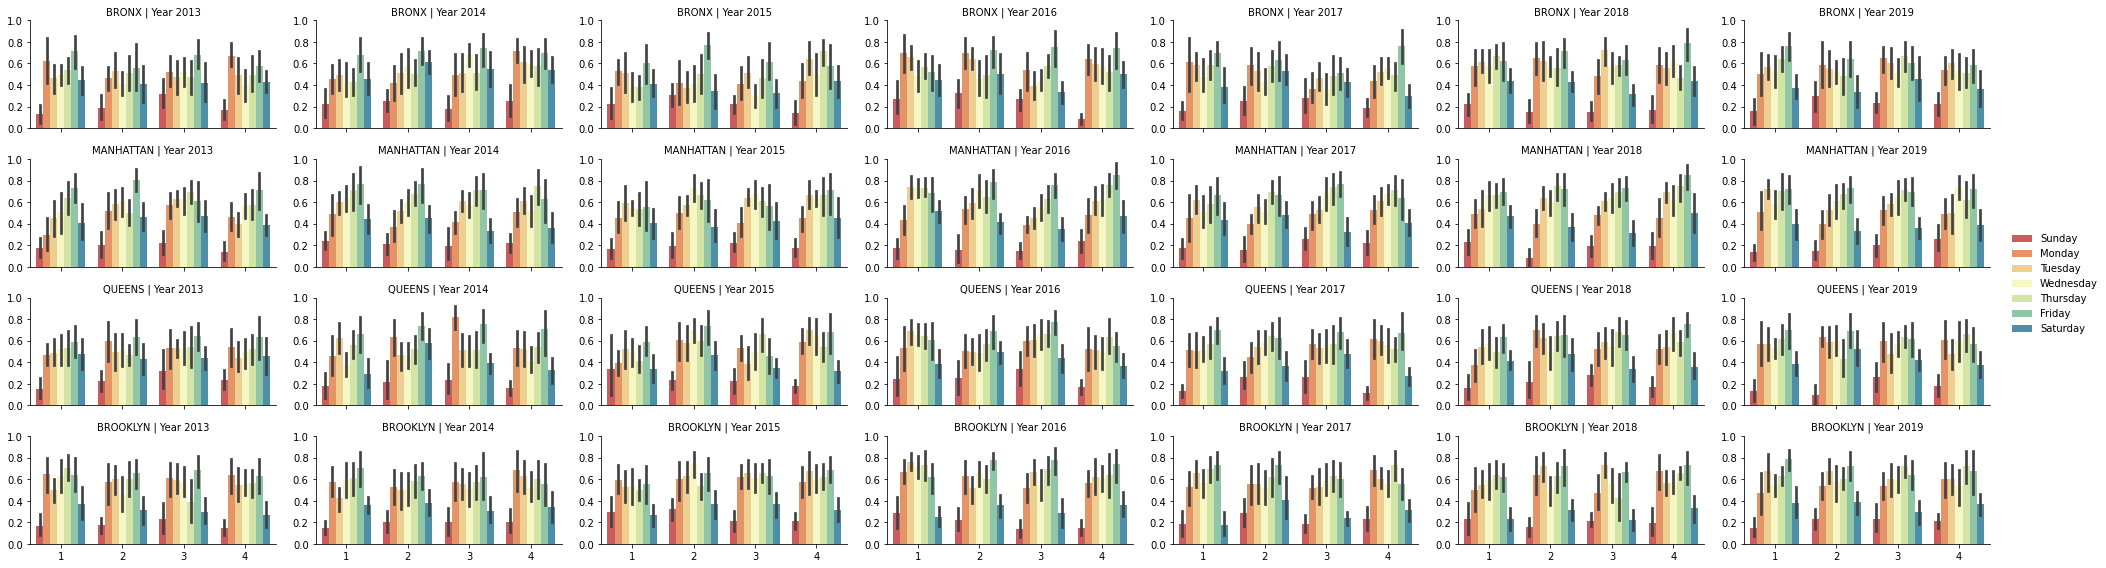

In [81]:
norm_plot = collision_df6.copy()
norm_plot['year'] = norm_plot.index.year
norm_plot['quarter'] = norm_plot.index.quarter
norm_plot['month'] = norm_plot.index.month_name()
norm_plot['day'] = norm_plot.index.day_name()
norm_plot['yearday_num'] = norm_plot.index.dayofyear
norm_plot['weekday_num'] = norm_plot.index.dayofweek
norm_plot['weekday_num'] = norm_plot['weekday_num'].apply(lambda x: 0 if x == 6 else x + 1)

norm_plot = norm_plot.melt(id_vars=['year', 'quarter', 'month', 'day', 'yearday_num', 'weekday_num'], value_vars=['BRONX', 'BROOKLYN','MANHATTAN','QUEENS',], var_name = 'borough', value_name = 'collisions')

g = sns.FacetGrid(norm_plot.sort_values('weekday_num'), row = 'borough', col='year', sharey=False, height = plot_height, aspect = 2)
g.map_dataframe(sns.barplot, x='quarter', y = 'collisions', hue='day', palette="Spectral")
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend()
g.set(ylim=(0, 1))

## Processing the Weather Data
The Weather data has largely been processed in the query. The only extra processing it may need is filling in null data and turning character/objects to floats.

The columns in the weather data and the key for missing values are:

Column name | Meaning | Missing Value
---|---|---
`year`, `mo`, and `da`| Year, Month, and day | -
`temp` |Mean Temperature in fahrenheit | `9999.9`
`dewp` |Mean Dew Point in fahrenheit | `9999.9`
`slp` |Sea Level Pressure in millibars  | `9999.9`
`visib` |Mean Visibility in Miles  | `999.9`
`wdsp` |Mean Wind Speed in knots  | `999.9`
`mxpsd` |Maximum sustained Wind Speed in knots  | `999.9`
`gust` |Maximum Wind Gust in knots  | `999.9`
`max` |Maximum Temperature in Fahrenheit | `9999.9`
`min` |Minimum Temperature in Fahrenheit | `9999.9`
`prcp` |Total Precipitation in inches | `99.99`
`sndp` |Snow depth in inches | `999.9`
`fog` |Yes = 1, No = 0 | -

And the head of the data frame looks like:

In [52]:
weather_df.head()

,date,year,mo,da,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog
0,2012-01-01,2012,1,1,46.6,38.2,1015.2,10.0,5.2,13.0,17.1,51.1,35.6,0.01,999.9,0
1,2012-01-02,2012,1,2,42.1,25.6,1006.7,9.8,8.9,18.1,22.9,51.1,36.0,0.05,999.9,0
2,2012-01-03,2012,1,3,28.5,12.4,1011.7,10.0,8.8,15.0,24.1,39.9,21.9,0.00,999.9,0
3,2012-01-04,2012,1,4,18.4,1.1,1020.4,10.0,7.2,22.0,999.9,27.0,12.9,0.00,999.9,0
4,2012-01-05,2012,1,5,31.6,15.4,1013.2,10.0,5.8,13.0,18.1,39.9,27.0,0.00,999.9,0


The non-date data imported is set as a float with `astype(float)`. This is to make sure that the data is numerical and not character or object.

The recorded values are cleaned for the unavailable data and replaced with an `np.nan` value from the Numpy library. This is because some mathematical functions don't work properly with Python's standard `NoneType`. 

In [53]:
weather_df.loc[:, 'temp':'fog'] = weather_df.loc[:, 'temp':'fog'].astype(float)
weather_df = weather_df.replace(9999.9, np.nan)
weather_df[['visib', 'wdsp', 'mxpsd', 'gust', 'sndp']] = weather_df[['visib', 'wdsp', 'mxpsd', 'gust', 'sndp']].astype(float).replace(999.9, np.nan)
weather_df['prcp'] = weather_df['prcp'].replace(99.99, np.nan)
weather_df.info()
print(f"{weather_df.value_counts('sndp')}, {weather_df.value_counts('fog')}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3261 entries, 0 to 3260
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3261 non-null   datetime64[ns]
 1   year    3261 non-null   int64         
 2   mo      3261 non-null   int64         
 3   da      3261 non-null   int64         
 4   temp    3261 non-null   float64       
 5   dewp    3260 non-null   float64       
 6   slp     3259 non-null   float64       
 7   visib   3261 non-null   float64       
 8   wdsp    3261 non-null   float64       
 9   mxpsd   3258 non-null   float64       
 10  gust    2057 non-null   float64       
 11  max     3261 non-null   float64       
 12  min     3261 non-null   float64       
 13  prcp    3236 non-null   float64       
 14  sndp    4 non-null      float64       
 15  fog     3261 non-null   float64       
dtypes: datetime64[ns](1), float64(12), int64(3)
memory usage: 433.1 KB
sndp
3.9    1
3.1    1
2.0   

Since there are only 4 days with snowdepth, `sndp`, and 2 states for `fog`, `0` or `1`, they will be dropped to simplify the dataset. There are a lot of `null` values in the `gust` column so it will be dropped.
The `da` is day of the month and this information at the scale the data is being viewed, without reference to the month, is largely just noise. If the day is a significant detail then it will be shown by the `date` column so the `da` will be dropped as well.

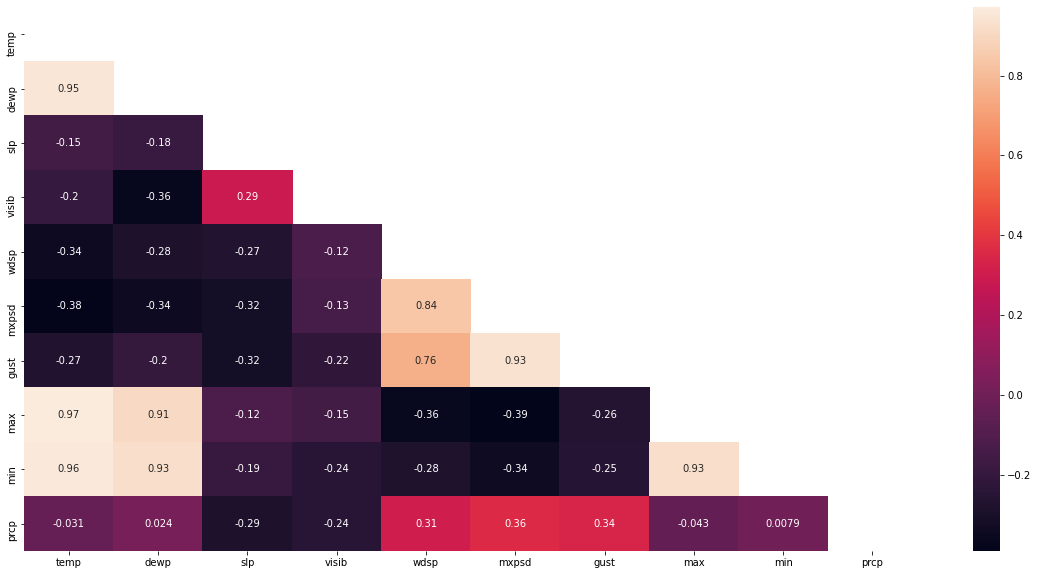

In [54]:
matrix = np.triu(weather_df.drop(['date', 'year', 'mo', 'da', 'sndp', 'fog'], axis=1).corr())
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(weather_df.drop(['date', 'year', 'mo', 'da', 'sndp', 'fog'], axis=1).corr(), mask=matrix, annot=True)

Based on the high correlation between the temperature `temp`, dew point `dewp` and the minimum and maximum temperatures `min`/`max` across the whole dataset, `temp` will be used in place of `dewp` and `min`/`max` values. 

Wind speed `wdsp` and max windspeed `mxpsd` also have high correlation so `mxpsd` will be dropped as well. Gust `gust` has a close correlation to `wdsp` but `gust` will be kept because the correlation is less than `0.8` and something interesting might exist there.

The values being dropped are generally related to another value being kept so their high correlation makes sense and the excess data is superfluous to creating the model.

This leaves Temperature `temp`, sea level pressure `slp`, visibility `visib`, wind speed `wdsp`, gust `gust`, and precipitation `prcp` as the current working variables.

### Viewing weather data in a scatter across time

The weather data is plotted across its full date range to see how the data lies.

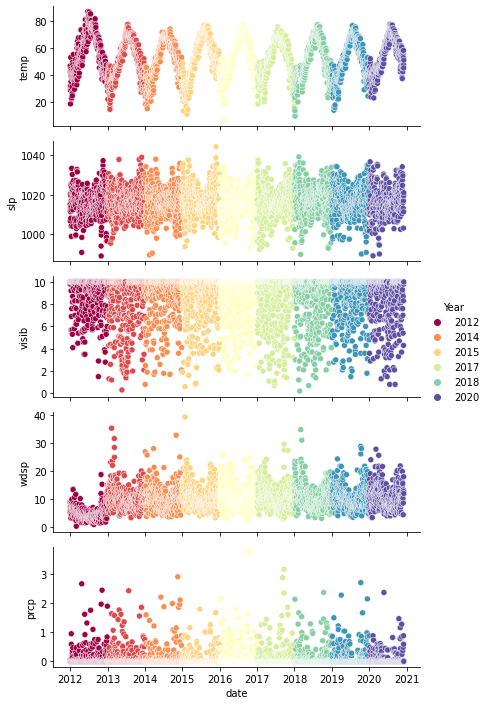

In [82]:
g = sns.PairGrid(data = weather_df, hue='year', palette="Spectral",
            x_vars = ['date'],
            y_vars = ['temp', 'slp', 'visib', 'wdsp', 'prcp'],
            height = plot_height, aspect = plot_aspect,
            )
g.map(sns.scatterplot,)
g.add_legend(title='Year')

The visibility `visib` and precipitation `prcp` generally have a default levels of `10` and `0`. Since there is so little variation in the data it is expected to not yield any insight.

The chosen data from the weather shall then be just temperature `temp`, sea level pressure `slp`, windspeed `wdsp`, and gust `gust`.

In [121]:
weather_df2 = weather_df.drop(['year', 'mo', 'da', 'sndp','fog', 'visib', 'prcp', 'dewp', 'mxpsd', 'gust', 'max', 'min' ], axis=1)
weather_df2.set_index('date', inplace = True)
weather_df2.describe()

,temp,slp,wdsp
count,3261.000000,3259.000000,3261.000000
mean,52.379914,1016.701105,10.028734
std,14.255953,7.654604,4.468312
min,5.800000,989.000000,0.200000
25%,41.300000,1012.000000,6.800000
50%,52.600000,1016.600000,9.400000
75%,64.700000,1021.700000,12.600000
max,86.900000,1044.200000,39.300000


## Combining Weather and Collisions
Both datasets are ready to be combined into one dataset by date.

The weather data starts in the first of January, 2012, but the collision data starts in the first of July, 2012. So the rows with `None` in collision count columns are dropped from the dataset, trimming the weather data.

The length of the dataset remains the same as `collision_df3`.

For ease, the date column has also been set to the index for the dataset.

In [122]:
complete_df_tmp = pd.merge(weather_df2[(weather_df2.index >= collision_df6.index.min()) & (weather_df2.index <= collision_df6.index.max())], collision_df6, how="left", on=["date"])

complete_df = pd.DataFrame()
complete_df['date'] = collision_df6.index
complete_df.set_index('date', inplace = True)
complete_df['year'] = complete_df.index.year
complete_df['quarter'] = complete_df.index.quarter 
complete_df['month'] = complete_df.index.month_name()
complete_df['mo'] = complete_df.index.month
complete_df['day'] = complete_df.index.day_name()
complete_df['weekday_num'] = complete_df.index.dayofweek
complete_df['weekday_num'] = complete_df['weekday_num'].apply(lambda x: 0 if x == 6 else x + 1)

complete_df = complete_df.merge(complete_df_tmp, how="left", left_index=True, on='date')
complete_df.head()

,year,quarter,month,mo,day,weekday_num,temp,slp,wdsp,BRONX,BROOKLYN,MANHATTAN,QUEENS
date,,,,,,,,,,,,,
2013-01-01,2013,1,January,1,Tuesday,2,38.0,1008.8,15.0,0.000000,0.333333,0.055556,NaN
2013-01-02,2013,1,January,1,Wednesday,3,27.5,1013.4,12.4,0.857143,0.947368,NaN,0.190476
2013-01-03,2013,1,January,1,Thursday,4,21.8,1018.1,9.8,NaN,0.929825,0.703704,0.476190
2013-01-04,2013,1,January,1,Friday,5,32.2,1015.2,11.3,0.928571,0.666667,0.629630,0.357143
2013-01-05,2013,1,January,1,Saturday,6,37.3,1017.3,13.2,0.357143,NaN,0.000000,0.023810


## Viewing the collated weather and collision data

The Kernel Density Estimate (KDE) plot is similar to the histogram/scatter plot above, taking a bit longer to calculate but it's good at showing the trends of the data by giving contours to show where the most densly populated areas are. 



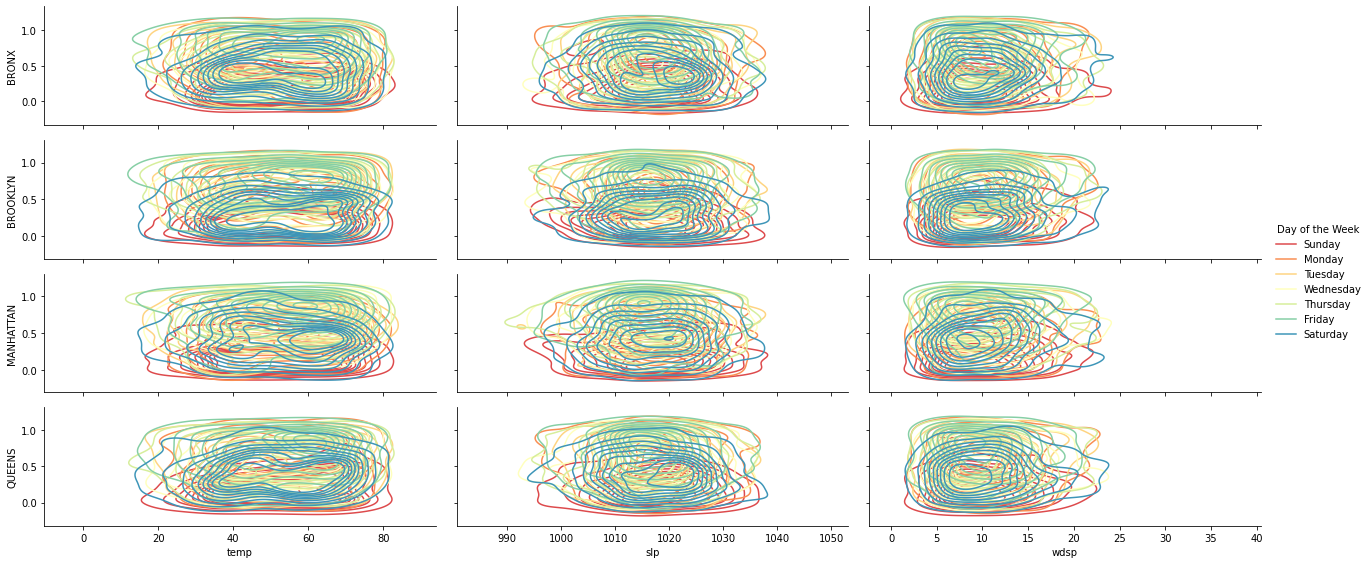

In [123]:
g = sns.PairGrid(data = complete_df.sort_values('weekday_num'), hue='day', palette="Spectral",
            x_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[:-len(collision_df6.columns)],
            y_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[-len(collision_df6.columns):],
            height = plot_height, aspect = plot_aspect,
            )
g.map(sns.kdeplot)
g.add_legend(title='Day of the Week')

From the `KDE` plot of the `collisions` by `borough`, the sea level pressure `slp`, visibility `visib`, windspeed `wdsp`, maxwindspeed `mxpsd`, gust  `gust`, and precipitation `prcp` show little seasonality change by `quarter`. However the temperature `temp`, dew point `dewp`, maximum temperature `max`, and minimum temperature `min` show a strong seasonal variation which is to be expected with lower temperature values in winter than in summer. Below the plots are modelled by year and the suggested reason why will be discussed further. 

Using seaborn, a range of scatter/histogram plots can be made where the density of the scatter is shown by the shade of the plot. The more dense the scatter the darker the plot.

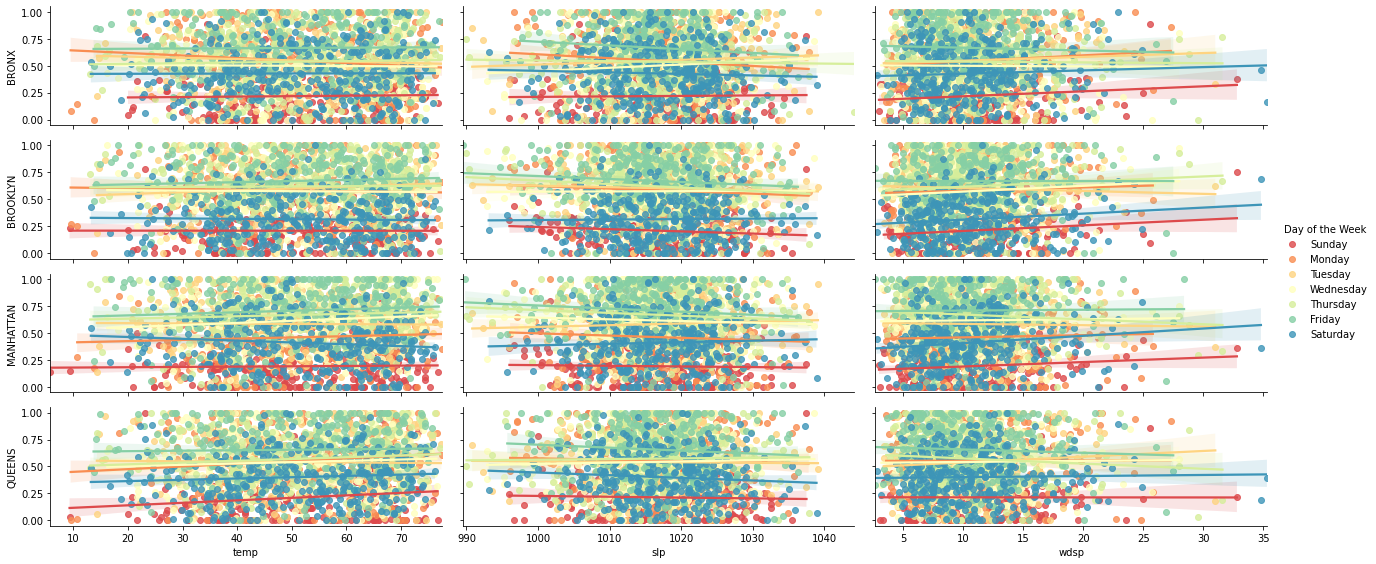

In [139]:
g = sns.PairGrid(data = complete_df.sort_values('weekday_num'), hue='day', palette="Spectral",
            x_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[:-len(collision_df6.columns)],
            y_vars = complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).columns[-len(collision_df6.columns):],
            height = plot_height, aspect = plot_aspect, 
            )
g.map(sns.regplot,)
g.add_legend(title='Day of the Week')

Looking at visibility `visib` and pricipitation `prcp` the data is largely concentrated at a threshold of `10` for visibility or `0` for pricipitation. This does not tell much about the data and leaves a large area for error where there is data so this data will be dropped.

### Correlation of collisions to weather

A general correlation between the chosen weather values and boroughs can be made and is shown below.

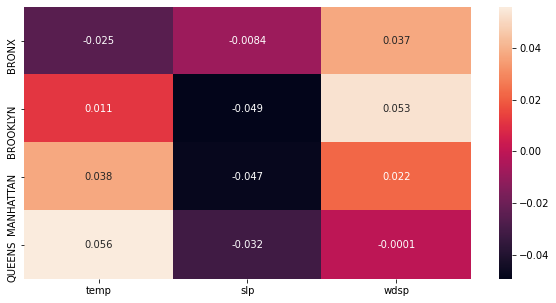

In [125]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(complete_df.drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr().iloc[-4:, :-4], annot=True)

In [126]:
corr_df = pd.DataFrame()

for year in complete_df.year.unique():
  for month in complete_df.month.unique():
    for weekday in complete_df.sort_values('weekday_num').weekday_num.unique():
      if corr_df.empty: 
        corr_df = complete_df[(complete_df.year == year) & (complete_df.month == month) & (complete_df.weekday_num == weekday)].drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr().iloc[-4:, :-4]
        corr_df.reset_index()
        corr_df['year'] = year
        corr_df['month'] = month
        corr_df['weekday_num'] = weekday
        corr_df['day'] = complete_df[(complete_df.year == year) & (complete_df.month == month) & (complete_df.weekday_num == weekday)].iloc[0].day
        corr_df['date'] = pd.to_datetime(f"{year}-{month}-{weekday+1}")
        corr_df = corr_df.rename_axis('borough').reset_index() 
        corr_df['quarter'] = corr_df.date.dt.quarter 
      else:
        corr_df_tmp = complete_df[(complete_df.year == year) & (complete_df.month == month) & (complete_df.weekday_num == weekday)].drop(['year', 'quarter', 'mo', 'month', 'weekday_num', 'day'], axis=1).corr().iloc[-4:, :-4]
        corr_df_tmp.reset_index()
        corr_df_tmp['year'] = year
        corr_df_tmp['month'] = month
        corr_df_tmp['weekday_num'] = weekday
        corr_df_tmp['day'] = complete_df[(complete_df.year == year) & (complete_df.month == month) & (complete_df.weekday_num == weekday)].iloc[0].day
        corr_df_tmp['date'] = pd.to_datetime(f"{year}-{month}-{weekday+1}")
        corr_df_tmp = corr_df_tmp.rename_axis('borough').reset_index()
        corr_df_tmp['quarter'] = corr_df_tmp.date.dt.quarter
        corr_df = corr_df.append(corr_df_tmp, ignore_index=True)       
corr_df.head()

,borough,temp,slp,wdsp,year,month,weekday_num,day,date,quarter
0,BRONX,-1.000000,1.000000,1.000000,2013,January,0,Sunday,2013-01-01,1
1,BROOKLYN,-0.587503,0.934274,0.861852,2013,January,0,Sunday,2013-01-01,1
2,MANHATTAN,-0.824372,0.452428,0.832697,2013,January,0,Sunday,2013-01-01,1
3,QUEENS,0.946363,-0.853382,-0.508108,2013,January,0,Sunday,2013-01-01,1
4,BRONX,0.987153,-0.982998,0.759495,2013,January,1,Monday,2013-01-02,1


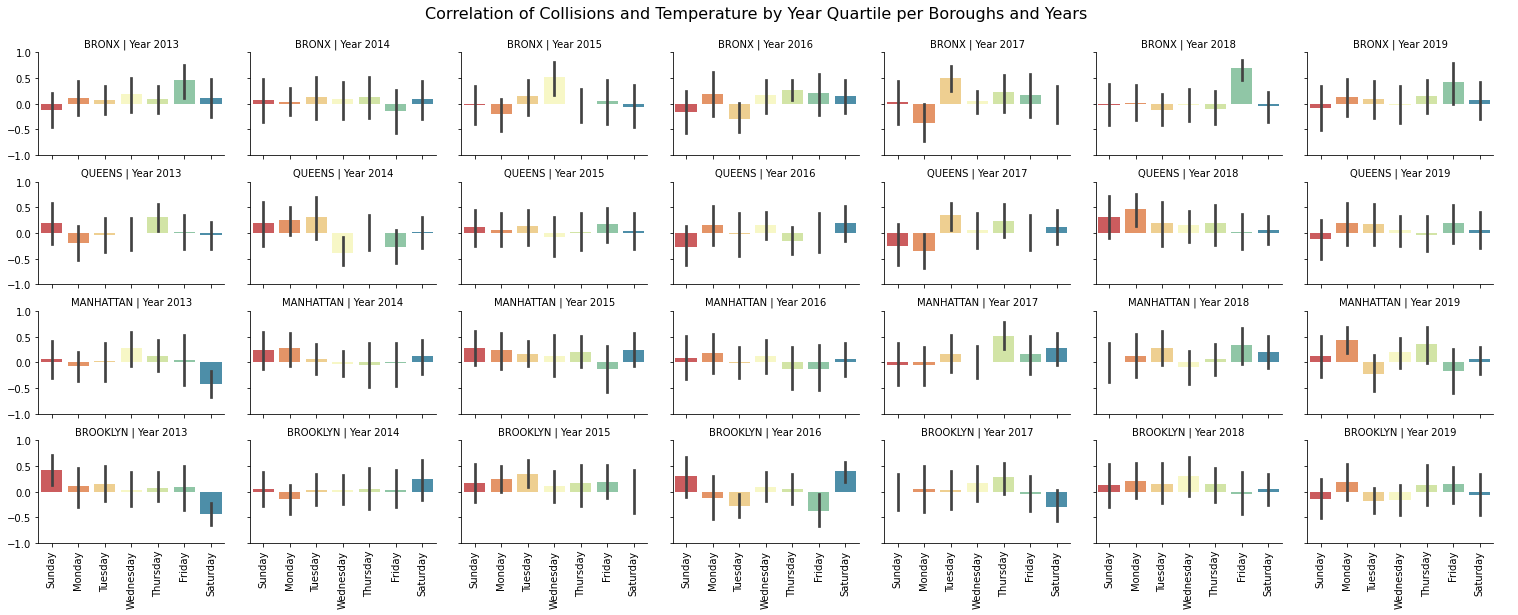

In [127]:
g = sns.FacetGrid(corr_df.sort_values('weekday_num'), row = 'borough', col='year', height = plot_height, aspect = plot_aspect/2)
g.map_dataframe(sns.barplot, x='day', y = 'temp', palette="Spectral")
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend()

g.set(ylim=(-1,1))

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation of Collisions and Temperature by Year Quartile per Boroughs and Years', fontsize=16)

g.set_xticklabels(rotation=90)

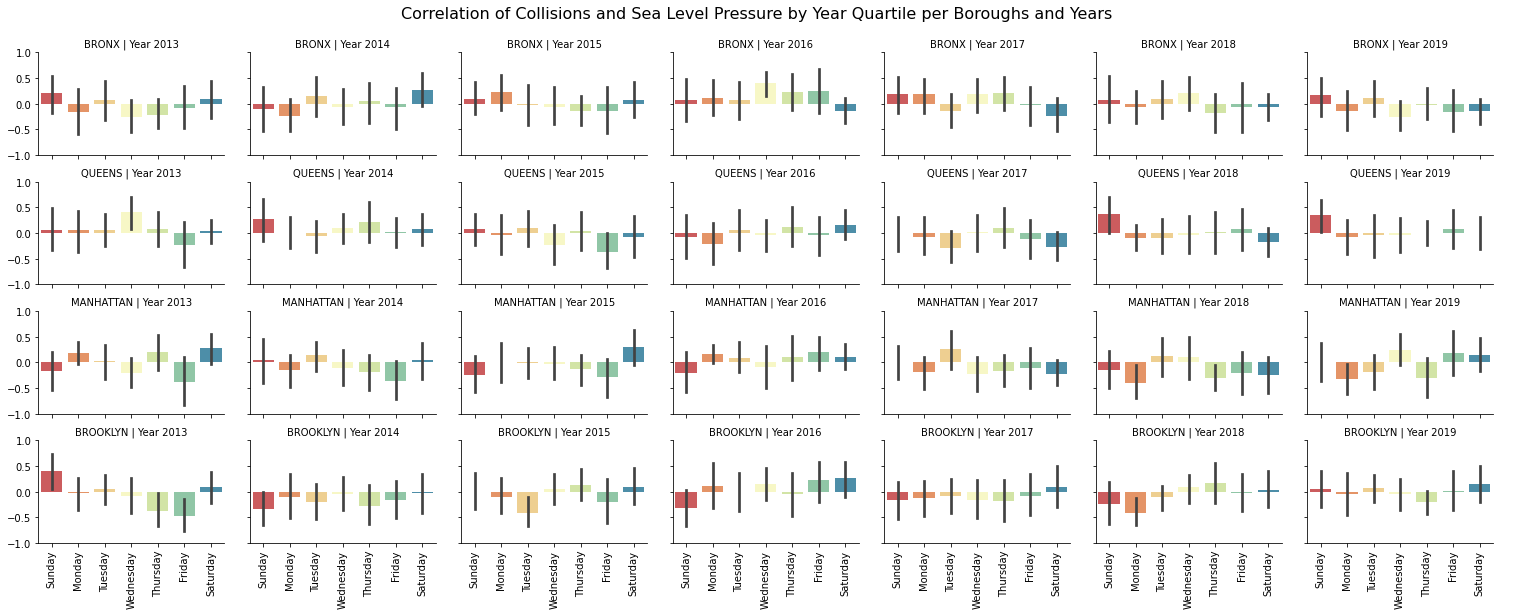

In [128]:
g = sns.FacetGrid(corr_df.sort_values('weekday_num'), row = 'borough', col='year', height = plot_height, aspect = plot_aspect/2)
g.map_dataframe(sns.barplot, x='day', y = 'slp', palette="Spectral")
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend()

g.set(ylim=(-1,1))

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation of Collisions and Sea Level Pressure by Year Quartile per Boroughs and Years', fontsize=16)
g.set_xticklabels(rotation=90)

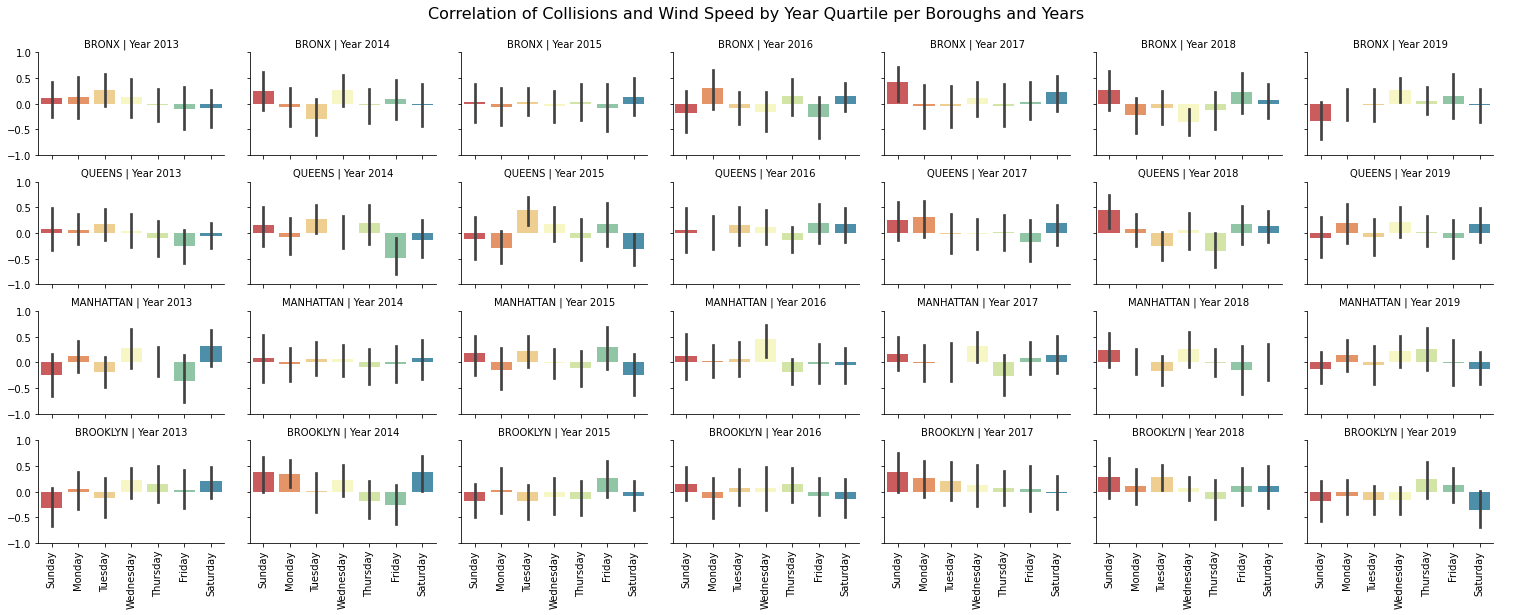

In [129]:
g = sns.FacetGrid(corr_df.sort_values('weekday_num'), row = 'borough', col='year', height = plot_height, aspect = plot_aspect/2)
g.map_dataframe(sns.barplot, x='day', y = 'wdsp', palette="Spectral")
g.set_titles(col_template="Year {col_name}", row_template="{row_name}")
g.tight_layout()
g.add_legend()

g.set(ylim=(-1,1))

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation of Collisions and Wind Speed by Year Quartile per Boroughs and Years', fontsize=16)
g.set_xticklabels(rotation=90)

In [130]:
corr_df[corr_df.borough == 'BRONX'].drop(['borough', 'year', 'month', 'weekday_num', 'day', 'date', 'quarter'], axis=1).describe().loc[['mean', 'std'], :]

,temp,slp,wdsp
mean,0.080914,0.012451,0.021256
std,0.654872,0.653811,0.656986


In [131]:
corr_df[corr_df.borough == 'BROOKLYN'].drop(['borough', 'year', 'month', 'weekday_num', 'day', 'date', 'quarter'], axis=1).describe().loc[['mean', 'std'], :]

,temp,slp,wdsp
mean,0.060111,-0.060396,0.043720
std,0.632757,0.646423,0.648368


In [132]:
corr_df[corr_df.borough == 'MANHATTAN'].drop(['borough', 'year', 'month', 'weekday_num', 'day', 'date', 'quarter'], axis=1).describe().loc[['mean', 'std'], :]

,temp,slp,wdsp
mean,0.093847,-0.057925,0.030095
std,0.647842,0.629236,0.652497


In [133]:
corr_df[corr_df.borough == 'QUEENS'].drop(['borough', 'year', 'month', 'weekday_num', 'day', 'date', 'quarter'], axis=1).describe().loc[['mean', 'std'], :]

,temp,slp,wdsp
mean,0.061427,0.003608,0.031652
std,0.640003,0.636272,0.639885


In [134]:
corr_df[corr_df.day == 'Sunday'].drop(['borough', 'year', 'month', 'weekday_num', 'day', 'date', 'quarter'], axis=1).describe().loc[['mean', 'std'], :]

,temp,slp,wdsp
mean,0.054357,0.011620,0.082279
std,0.708427,0.689397,0.697253


In [135]:
corr_df.drop(['borough', 'year', 'month', 'weekday_num', 'day', 'date', 'quarter'], axis=1).describe().loc[['mean', 'std'], :]

,temp,slp,wdsp
mean,0.074069,-0.025522,0.031677
std,0.643666,0.641998,0.649100


From the data plotted above the temperature `temp` and wind speed `wdsp` appear to have the highest correlation factor so those two datasets will be chosen as details for the linear regressor model in predicting collisions.

Temperature appears to have the largest mean value at `0.074` with a reasonable standar deviation `std` of `0.64`, implying the highest correlation value on average between collisions and a weather value. The wind speed `wdsp` has the second highest correlation value of `0.031` with a reasonable standard deviation similiarly of about `0.65`. Gust `gust` has the highest standard deviation of `0.81`, meaning the data is spread out, and the lowest mean value at `-0.002 `, a value closer to zero means there is lower correlation.

## Linear Data

This is the dataset to be used in the Linear Analysis.

In [136]:
Linear_complete_df = complete_df.drop(['year', 'quarter', 'mo', 'month', 'day'], axis=1)
Linear_complete_df['collisions'] = collision_df5.sum(axis=1)
Linear_complete_df = Linear_complete_df.drop(collision_df5.columns, axis=1)
Linear_complete_df.head()

,weekday_num,temp,slp,wdsp,collisions
date,,,,,
2013-01-01,2,38.0,1008.8,15.0,225.0
2013-01-02,3,27.5,1013.4,12.4,311.0
2013-01-03,4,21.8,1018.1,9.8,375.0
2013-01-04,5,32.2,1015.2,11.3,413.0
2013-01-05,6,37.3,1017.3,13.2,219.0


## Creating Dummy Variables for One Hot Encoding

Two new columns are made for the name of the day and the name of the month. These values are turned into 'dummies', where the data is transferred to the header and the column is marked with an entry of `1` or `0` depending on that `date`. This is called One Hot Encoding and prepares string variables for modeling.

Once the Month and Day datasets have been encoded with dummy variables, they are merged together on their respective `date index`, before being merged with the main dataset, again by the `date index`.

In [137]:
OHE_month_day = pd.merge(pd.get_dummies(complete_df.month), pd.get_dummies(complete_df.day), left_index=True, right_index=True)
OHE_complete_df = pd.merge(complete_df.drop(['year', 'quarter', 'mo', 'month', 'day', 'weekday_num'], axis=1), OHE_month_day, left_index=True, right_index=True)
OHE_complete_df.head()

,temp,slp,wdsp,BRONX,BROOKLYN,MANHATTAN,QUEENS,April,August,December,February,January,July,June,March,May,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,38.0,1008.8,15.0,0.000000,0.333333,0.055556,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2013-01-02,27.5,1013.4,12.4,0.857143,0.947368,NaN,0.190476,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-01-03,21.8,1018.1,9.8,NaN,0.929825,0.703704,0.476190,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2013-01-04,32.2,1015.2,11.3,0.928571,0.666667,0.629630,0.357143,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-05,37.3,1017.3,13.2,0.357143,NaN,0.000000,0.023810,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## Saving the dataset to Google Drive's `My Drive`

Now the data is prepared, it is ready to be saved. 
Running the code below saves the data to the user's google drive under `My Drive`. The string saying `Dataset Successfully Saved!` will notify the user that a copy of the dataset has been saved to their google drive. 

*(Unless changed above, `save_collision_data` will be `False`)*

In [141]:
if save_collision_data:
  if not auth:
    from google.colab import auth
    auth.authenticate_user()
  if not drive:
    from google.colab import drive
    drive.mount('drive')

  OHE_complete_df.to_csv('Tom_Blackwood-OHE-Weather_and_Collision_data_for_New_York_boroughs_2012-2020.csv')
  !cp Tom_Blackwood-OHE-Weather_and_Collision_data_for_New_York_boroughs_2012-2020.csv "drive/My Drive"

  Linear_complete_df.to_csv('Tom_Blackwood-Linear-Weather_and_Collision_data_for_New_York_boroughs_2012-2020.csv')
  !cp Tom_Blackwood-Linear-Weather_and_Collision_data_for_New_York_boroughs_2012-2020.csv "drive/My Drive"
  print("Datasets Successfully Saved!")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Datasets Successfully Saved!
